In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()

In [3]:
class Layer():
    
    def __init__(self, model, f, d_f, input_dims = None, output_dims = None, input_layer=False, output_layer=False, learning_rate=0.001):
        
        self.model = model
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.learning_rate = learning_rate
        
        # Parameters
        self.a = None
        self.z = None
        self.W = None
        self.b = None
        
        self.dW = None
        self.db = None
        self.da = None
        self.dz = None
        
        self.input_layer = input_layer
        self.output_layer = output_layer
        
        # Activation Functions
        self.f = f
        self.d_f = d_f
        
        # Adjacent layers set during backpropagation
        self.next_layer = None
        self.prev_layer = None
    
    
    def random_init(self):
        
        # Kaiming Weight Initialization
        self.W = np.random.randn(self.output_dims, self.input_dims)*np.sqrt(2)/np.sqrt(self.input_dims)
        
        # Xavier Weight Initialization
        B = np.sqrt(6)/np.sqrt(self.input_dims + self.output_dims)
        self.W = np.random.uniform(low=-B , high=B ,size=(self.output_dims, self.input_dims))
        
        self.b = np.zeros(shape=(self.output_dims, 1))
      
    
    def get_prev_a(self):
        if self.input_layer:
            return self.model.data
        return self.prev_layer.a
    

    def forward_pass(self):
        prev_a = self.get_prev_a()
        self.z = self.W.dot(prev_a) + self.b
        self.a = self.f(self.z)
        
    
    def backpropagate(self):
        prev_a = self.get_prev_a()
        
        if self.output_layer:
            delta = self.model.calc_d_J(self.a)
        else:
            delta = self.next_layer.da
            
        m = prev_a.shape[1]
        
        self.dz = delta * self.d_f(self.z)
        self.dW = self.dz.dot(prev_a.T)/m
        self.db = np.sum(self.dz, axis=1, keepdims=True)
        self.da = self.W.T.dot(self.dz)
        
    def learn(self):
        self.W = self.W - self.learning_rate * self.dW
        self.b = self.b - self.learning_rate * self.db
    

In [4]:
class NeuralNetwork():
    
    def __init__(self, architecture, input_size, cost_function, train_data=None, train_labels=None, learning_rate=0.001):
        
        self.learning_rate = learning_rate
        
        # Create Layers
        self.layers = self.create_layers(architecture, input_size)
        
        # Data
        self.data = train_data
        self.labels = train_labels
        
        # Cost Function
        self.J, self.d_J = cost_functions[cost_function]
        
    
    def calc_J(self, y_hat):
        return self.J(self.labels, y_hat)
    
    
    def calc_d_J(self, y_hat):
        return self.d_J(self.labels, y_hat)
    
    
    def calc_accuracy(self, test_data, test_labels):
        self.data = test_data
        self.labels = test_labels
        
        # Forward Pass and get output
        self.forward_pass()
        y_hat = self.layers[-1].a
        
        y_pred = np.where(y_hat > 0.5, 1, 0)
        return (y_pred == self.labels).mean()
    
    def create_layers(self, architecture, input_size):
        
        layers = []
        
        for i, config in enumerate(architecture):
            input_dims = input_size if i == 0 else layers[-1].output_dims
            output_dims = config["num_nodes"]
            f, d_f = activation_functions[config["activation"]]
            layer = Layer(self, f, d_f, input_dims, output_dims, input_layer=(i==0), output_layer=(i==len(architecture)-1), learning_rate=self.learning_rate)
            
            if i != 0:
                layers[-1].next_layer = layer
                layer.prev_layer = layers[-1]
            
            
            layers.append(layer)
        
        for layer in layers:
            layer.random_init()
            
        return layers
    
    def add_data(self, train_data, train_labels):
        self.data = train_data
        self.labels = train_labels
        
    def forward_pass(self):
        for layer in self.layers:            
            layer.forward_pass()
            
    def backward_pass(self):
        for layer in reversed(self.layers):
            layer.backpropagate()

    def learn(self):
        for layer in self.layers:
            layer.learn()
    
    def train(self, epochs):
        history = []
        for i in list(range(epochs)):
            self.forward_pass()
            cost = self.calc_J(self.layers[-1].a)
            history.append(cost)
            if i % 50 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))        
            self.backward_pass()
            self.learn()
        
        # Training done. Return history
        return history


In [5]:
# COST FUNCTIONS

def cross_entropy_sigmoid(y, y_hat):
    m = y.shape[1]
    cost = (1./m) * (-np.dot(y,np.log(y_hat).T) - np.dot(1-y, np.log(1-y_hat).T))
    cost = np.squeeze(cost)
    return cost


def cross_entropy_sigmoid_derivative(y, y_hat):
    m = y.shape[1]
    return (-(np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat)))


def mean_squared(y, y_hat):
    return  np.sum((y - y_hat)**2 ).squeeze() / (y_hat.shape[1]*2)

def d_mean_squared(y, y_hat):
    return (y_hat - y)


cost_functions = {"cross_entropy_sigmoid" : (cross_entropy_sigmoid, cross_entropy_sigmoid_derivative),
                  "mean_squared" : (mean_squared, d_mean_squared)
                 }

In [6]:
# ACTIVATION FUNCTIONS

import numpy as np

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def d_sigmoid(x):
    s = sigmoid(x)
    return s*(1-s)

def relu(x):
    return np.maximum(0,x)

def d_relu(x):
    r = np.where(x > 0, 1, 0)
    return r

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    d = tanh(x)
    return 1 - d*d


activation_functions = {"sigmoid" : (sigmoid, d_sigmoid) , "relu" : (relu, d_relu), "tanh" : (tanh, d_tanh)}

# Application on Cancer Dataset

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import tqdm

In [8]:
X, y = load_breast_cancer(return_X_y=True)
y = y.reshape((len(y), 1))

# Split Data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
train_X = train_X.T
test_X = test_X.T

# Normalize
mean = np.mean(train_X, axis = 1, keepdims=True)
std_dev = np.std(train_X, axis = 1, keepdims=True)
train_X = (train_X - mean)/std_dev
test_X = (test_X - mean)/std_dev

train_y = train_y.T
test_y = test_y.T


In [9]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((30, 455), (1, 455), (30, 114), (1, 114))

Cost after iteration 0: 0.736730
Cost after iteration 50: 0.681218
Cost after iteration 100: 0.674499
Cost after iteration 150: 0.667865
Cost after iteration 200: 0.661389
Cost after iteration 250: 0.655133
Cost after iteration 300: 0.649133
Cost after iteration 350: 0.643402
Cost after iteration 400: 0.637931
Cost after iteration 450: 0.632698
Cost after iteration 500: 0.627680
Cost after iteration 550: 0.622850
Cost after iteration 600: 0.618185
Cost after iteration 650: 0.613665
Cost after iteration 700: 0.609273
Cost after iteration 750: 0.604994
Cost after iteration 800: 0.600817
Cost after iteration 850: 0.596734
Cost after iteration 900: 0.592737
Cost after iteration 950: 0.588820


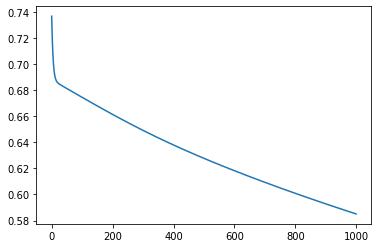

In [12]:
description = [{"num_nodes" : 100, "activation" : "sigmoid"},
               {"num_nodes" : 50, "activation" : "sigmoid"},
               {"num_nodes" : 1, "activation" : "sigmoid"}]

model = NeuralNetwork(description,30,"cross_entropy_sigmoid", train_X, train_y, learning_rate=0.001)

history = model.train(1000)

plt.plot(history)

In [13]:
acc = model.calc_accuracy(train_X, train_y)
print("Accuracy of the model on the training set is = {}".format(acc))

acc = model.calc_accuracy(test_X, test_y)
print("Accuracy of the model on the test set is = {}".format(acc))

Accuracy of the model on the training set is = 0.643956043956044
Accuracy of the model on the test set is = 0.5877192982456141
